In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task :
- Build a modular vision model with shared base features and multiple specialized
- processing units ("experts").
- Implement a dynamic routing mechanism that selects appropriate expert modules based on input data characteristics.
- Ensure that the model supports at least two tasks concurrently (e.g., disease grading classification and lesion segmentation).

Objective : To design a single multitask model that dynamically routes each input to the appropriate expert head (segmentation or classification) using a gating network trained alongside the task heads. To make the system adaptive to data characteristics.

General approach  as follows : _

Image -> ConvNeXt Encoder (shared) -> Gated MLP (routing seg/cls)
                                                  
                                                  ↓
                                            ┌─────┴──────┐
                                            ↓            ↓
                                      Seg Head      Cls Head




In [3]:
import os
import json
from pathlib import Path

In [ ]:
import json
from pathlib import Path

# === Config === #choose dataset paths here
base_dir = "/content/drive/MyDrive/idrid_dataset/A. Segmentation"
train_img_dir = Path(base_dir) / "1. Original Images" / "b. Testing Set"

mask_base_dir = Path(base_dir) / "2. All Segmentation Groundtruths" / "b. Testing Set"
lesion_dirs = {
    "MA": mask_base_dir / "1. Microaneurysms",
    "HE": mask_base_dir / "2. Haemorrhages",
    "EX": mask_base_dir / "3. Hard Exudates",
    "SE": mask_base_dir / "4. Soft Exudates",
    "OD": mask_base_dir / "5. Optic Disc"
}

#  Load imgs
entries = []
for file in train_img_dir.glob("*.jpg"):
    image_id = file.stem  # Gets filename without extension

    entry = {
        "image_path": str(file.resolve()),  # Absolute image path
        "task": "seg",
        "task_vector": [1, 0],               # FiLM conditioning vector
        "mask_paths": {}                     # Holds each lesion
    }

    # Add each lesion mask path (if available)
    for lesion, dir_path in lesion_dirs.items():
        mask_filename = f"{image_id}_{lesion}.tif"
        mask_path = dir_path / mask_filename
        entry["mask_paths"][lesion] = str(mask_path.resolve()) if mask_path.exists() else None

    entries.append(entry)

# Save JSON path
output_path = "/content/drive/MyDrive/Colab Notebooks/metadata_idrid/segmentation_metadata_test.json"
with open(output_path, "w", encoding='utf-8') as f:
    json.dump(entries, f, indent=4, ensure_ascii=False)

print(f"Saved {len(entries)} entries to {output_path}")
print(f" Sample entry:\n{json.dumps(entries[0], indent=2) if entries else 'No entries'}")


with open(output_path, "r", encoding='utf-8') as f:
    test_load = json.load(f)



Saved 27 entries to /content/drive/MyDrive/Colab Notebooks/metadata_idrid/segmentation_metadata_test.json
 Sample entry:
{
  "image_path": "/content/drive/MyDrive/idrid_dataset/A. Segmentation/1. Original Images/b. Testing Set/IDRiD_75.jpg",
  "task": "seg",
  "task_vector": [
    1,
    0
  ],
  "mask_paths": {
    "MA": "/content/drive/MyDrive/idrid_dataset/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/1. Microaneurysms/IDRiD_75_MA.tif",
    "HE": "/content/drive/MyDrive/idrid_dataset/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/2. Haemorrhages/IDRiD_75_HE.tif",
    "EX": "/content/drive/MyDrive/idrid_dataset/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/3. Hard Exudates/IDRiD_75_EX.tif",
    "SE": "/content/drive/MyDrive/idrid_dataset/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/4. Soft Exudates/IDRiD_75_SE.tif",
    "OD": "/content/drive/MyDrive/idrid_dataset/A. Segmentation/2. All Segmentation Groundtruths/b

In [ ]:
import json
import pandas as pd
from pathlib import Path

# === Config ===
cls_img_dir = Path("/content/drive/MyDrive/idrid_dataset/B. Disease Grading/1. Original Images/b. Testing Set")
csv_path = Path("/content/drive/MyDrive/idrid_dataset/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv")

# === Load labels from CSV ===
df = pd.read_csv(csv_path)

entries = []
for _, row in df.iterrows():
    img_id = str(row['Image name']).strip()
    img_path = cls_img_dir / f"{img_id}.jpg"

    if not img_path.exists():
        print(f"Skipping missing image: {img_path}")
        continue

    entry = {
        "image_path": str(img_path.resolve()),
        "task": "cls",
        "task_vector": [0, 1],
        "retino_label": int(row['Retinopathy grade']),
        "edema_label": int(row['Risk of macular edema '])
    }
    entries.append(entry)

# === Save classification metadata ===
output_path = "/content/drive/MyDrive/Colab Notebooks/metadata_idrid/classification_metadata_test.json"
with open(output_path, "w", encoding='utf-8') as f:
    json.dump(entries, f, indent=4, ensure_ascii=False)

print(f"Saved {len(entries)} classification entries to {output_path}")
print(f"Sample entry:\n{json.dumps(entries[0], indent=2) if entries else 'No entries'}")

# === Verify the JSON can be reloaded ===

with open(output_path, "r", encoding='utf-8') as f:
    test_load = json.load(f)
print("JSON verification successful")



Saved 103 classification entries to /content/drive/MyDrive/Colab Notebooks/metadata_idrid/classification_metadata_test.json
Sample entry:
{
  "image_path": "/content/drive/MyDrive/idrid_dataset/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_001.jpg",
  "task": "cls",
  "task_vector": [
    0,
    1
  ],
  "retino_label": 4,
  "edema_label": 0
}
JSON verification successful


In [ ]:
import json

# Load segmentation metadata
with open("/content/drive/MyDrive/Colab Notebooks/metadata_idrid/segmentation_metadata_train.json", "r", encoding="utf-8") as f:
    seg_data = json.load(f)

# Load classification metadata
with open("/content/drive/MyDrive/Colab Notebooks/metadata_idrid/classification_metadata_train.json", "r", encoding="utf-8") as f:
    cls_data = json.load(f)

# Combine
combined_data = seg_data + cls_data

# (Optional) Shuffle the combined list
import random
random.shuffle(combined_data)

# Save to meta.json
with open("/content/drive/MyDrive/Colab Notebooks/metadata_idrid/combined_meta_train.json", "w", encoding="utf-8") as f:
    json.dump(combined_data, f, indent=2, ensure_ascii=False)

print(f"Combined {len(seg_data)} segmentation and {len(cls_data)} classification entries.")
print(f"Saved as meta.json with total {len(combined_data)} samples.")


Combined 54 segmentation and 413 classification entries.
Saved as meta.json with total 467 samples.


In [ ]:
import json

# Load the segmentation metadata
with open('segmentation_metadata_train.json', 'r') as f:
    segmentation_data = json.load(f)

# Load the classification metadata
with open('classification_metadata_train.json', 'r') as f:
    classification_data = json.load(f)

# Combine the data
combined_data = segmentation_data + classification_data

# Save the combined data to a new JSON file
output_file_name = 'combined_idrid_metadata.json'
with open(output_file_name, 'w') as f:
    json.dump(combined_data, f, indent=2)

print(f"Successfully combined data into {output_file_name}. Total records: {len(combined_data)}")

# Optional: Display a few samples for verification
# print("\n--- Sample of combined metadata (first 2 records) ---")
# print(json.dumps(combined_data[:2], indent=2))

# print("\n--- Sample of combined metadata (last 2 records) ---")
# print(json.dumps(combined_data[-2:], indent=2))

Successfully combined data into combined_idrid_metadata.json. Total records: 467


In [ ]:
import json

with open("/content/drive/MyDrive/Colab Notebooks/metadata_idrid/combined_meta_train.json") as f:
    data = json.load(f)

seg_count = sum(1 for x in data if x['task'] == 'seg')
cls_count = sum(1 for x in data if x['task'] == 'cls')

print(f"In total JSON:")
print(f" Segmentation entries: {seg_count}")
print(f" Classification entries: {cls_count}")


In total JSON:
 Segmentation entries: 54
 Classification entries: 413


# augmenting data for segmentation since it is very imbalanced

In [ ]:
import json
from random import shuffle

# Load original combined JSON
with open("/content/drive/MyDrive/Colab Notebooks/metadata_idrid/combined_meta_train.json") as f:
    data = json.load(f)

seg = [x for x in data if x["task"] == "seg"]
cls = [x for x in data if x["task"] == "cls"]

# Oversample segmentation 8x (54*8 = 432)
seg_oversampled = seg * 8
balanced = seg_oversampled + cls
shuffle(balanced)

# Save
with open("/content/drive/MyDrive/Colab Notebooks/metadata_idrid/balanced_idrid_metadata.json", "w") as f:
    json.dump(balanced, f, indent=2)

print(f"Balanced dataset created with {len(balanced)} entries (Seg: {len(seg_oversampled)}, Cls: {len(cls)})")


Balanced dataset created with 845 entries (Seg: 432, Cls: 413)


In [ ]:
import json

with open("/content/drive/MyDrive/Colab Notebooks/metadata_idrid/balanced_idrid_metadata.json") as f:
    data = json.load(f)

seg_count = sum(1 for x in data if x['task'] == 'seg')
cls_count = sum(1 for x in data if x['task'] == 'cls')

print(f"In total JSON:")
print(f" Segmentation entries: {seg_count}")
print(f" Classification entries: {cls_count}")

In total JSON:
 Segmentation entries: 432
 Classification entries: 413


# Lets Begin : Steps
1) Create Train and test loaders from Json
2) Visualize loaders
3) Create Models : Segmentation, Classification, Gated Network, MultiClassGated
4) Train data
5) Evaluate
6) Predict

In [10]:
# combined dataloader

import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as T

# -----------------------------
# 1. Load Metadata
# -----------------------------
with open("/content/drive/MyDrive/Colab Notebooks/metadata_idrid/balanced_idrid_metadata.json", "r") as f:
    metadata = json.load(f)

# -----------------------------
# 2. Transform
# -----------------------------
transform = T.Compose([

    T.Resize((512, 512)),

    T.ColorJitter(brightness=0.1, contrast=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# -----------------------------
# 3. MultiTask Dataset
# -----------------------------
class MultiTaskIDRiDDataset(Dataset):
    def __init__(self, entries, transform=None):
        self.entries = entries
        self.transform = transform
        self.mask_keys = ["MA", "HE", "EX", "SE", "OD"]

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        entry = self.entries[idx]
        image = Image.open(entry["image_path"]).convert("RGB")

        if self.transform:
            image = self.transform(image)

        task_vector = torch.tensor(entry["task_vector"], dtype=torch.float32)

        if entry["task"] == "cls":
            label = torch.tensor([entry["retino_label"], entry["edema_label"]], dtype=torch.long)
            return image, task_vector, label

        elif entry["task"] == "seg":
            masks = []
            for key in self.mask_keys:
                mask_path = entry["mask_paths"].get(key)
                if mask_path is not None:
                    mask = Image.open(mask_path).resize((512, 512))
                    mask = np.array(mask) > 0
                else:
                    mask = np.zeros((512, 512), dtype=np.uint8)
                masks.append(mask.astype(np.float32))
            masks = np.stack(masks, axis=0)  # shape: (5, H, W)
            return image, task_vector, torch.tensor(masks)

def multitask_collate_fn(batch):
    images = []
    task_vecs = []
    targets_cls = []
    targets_seg = []

    for image, task_vec, target in batch:
        images.append(image)
        task_vecs.append(task_vec)
        if task_vec[1] == 1:  # classification
            targets_cls.append(target)
            targets_seg.append(None)
        else:  # segmentation
            targets_cls.append(None)
            targets_seg.append(target)

    images = torch.stack(images)
    task_vecs = torch.stack(task_vecs)

    return images, task_vecs, targets_cls, targets_seg


# -----------------------------
# 4. Dataset + Dataloader
# -----------------------------
dataset = MultiTaskIDRiDDataset(metadata, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=multitask_collate_fn)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, collate_fn=multitask_collate_fn)

# -----------------------------
# 5. Print Example Batch
# -----------------------------
print("Sample Batch Shapes:\n")


for images, task_vecs, targets_cls, targets_seg in train_loader:
    print(f" Image batch shape:     {images.shape}")
    print(f"Task vector batch:      {task_vecs}")
    print(f"Classification present: {[t is not None for t in targets_cls]}")
    print(f"Segmentation present:   {[t is not None for t in targets_seg]}")

    # Optional: check shape of first valid target
    for t in targets_cls:
        if t is not None:
            print(f"Classification shape: {t.shape}")
            break
    for t in targets_seg:
        if t is not None:
            print(f" Segmentation shape:   {t.shape}")
            break
    break

Sample Batch Shapes:

 Image batch shape:     torch.Size([4, 3, 512, 512])
Task vector batch:      tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])
Classification present: [True, True, True, False]
Segmentation present:   [False, False, False, True]
Classification shape: torch.Size([2])
 Segmentation shape:   torch.Size([5, 512, 512])


Visualize train loader


In [5]:
class UnNormalize:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(3, 1, 1)
        self.std = torch.tensor(std).view(3, 1, 1)

    def __call__(self, tensor):
        return tensor * self.std + self.mean


In [6]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def visualize_segmentation_sample(loader, class_names=["MA", "HE", "EX", "SE", "OD"], n_samples=1):
    #model.eval()  # Optional, in case model is used
    unnormalize = UnNormalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])

    for images, task_vecs, targets_cls, targets_seg in loader:
        for i in range(len(images)):
            if task_vecs[i, 0] == 1:  # segmentation task
                # Unnormalize image for visualization
                image = unnormalize(images[i].cpu()).clamp(0, 1)
                image_np = image.permute(1, 2, 0).numpy()  # (H, W, C)

                masks = targets_seg[i].numpy()  # shape (5, H, W)

                fig, axs = plt.subplots(1, 6, figsize=(15, 4))
                axs[0].imshow(image_np)
                axs[0].set_title("Input Image")
                axs[0].axis('off')

                for j in range(5):
                    axs[j + 1].imshow(masks[j], cmap='gray')
                    axs[j + 1].set_title(class_names[j])
                    axs[j + 1].axis('off')

                plt.tight_layout()
                plt.show()

                n_samples -= 1
                if n_samples == 0:
                    return


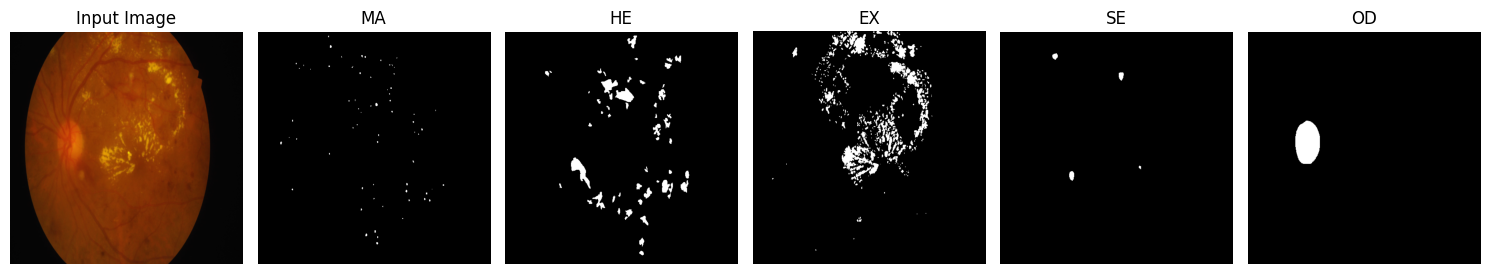

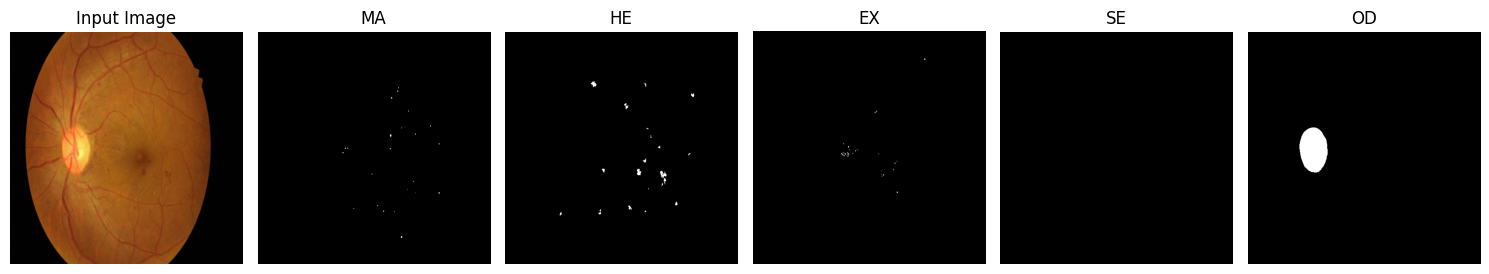

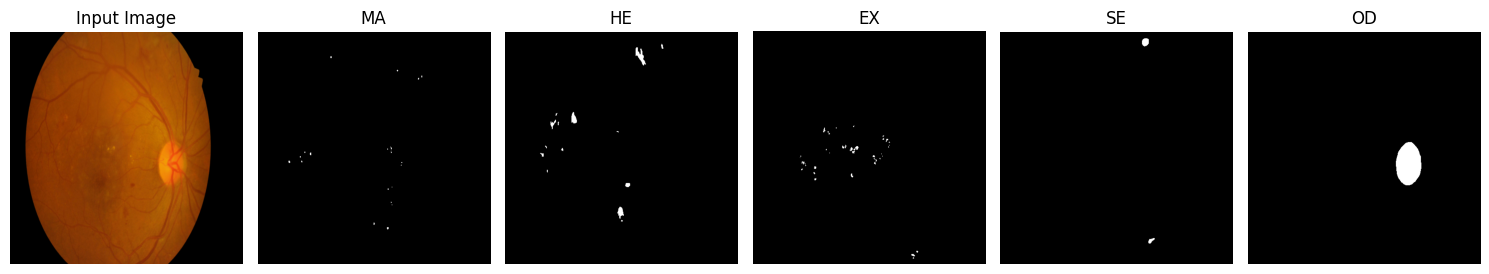

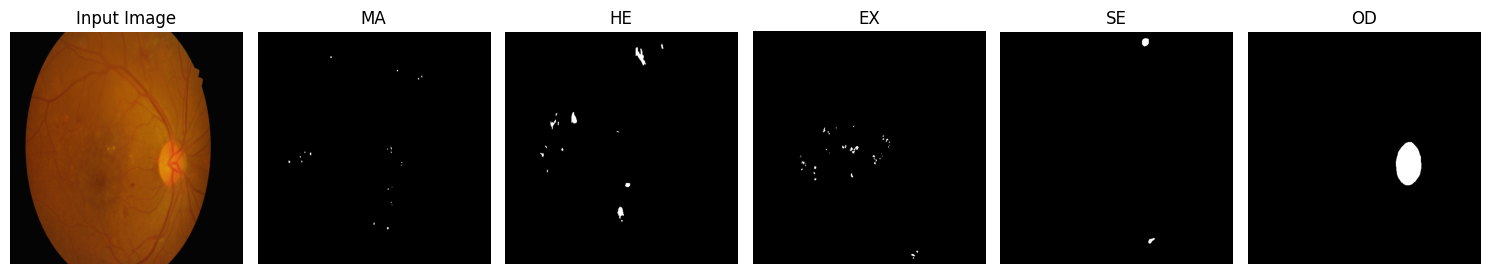

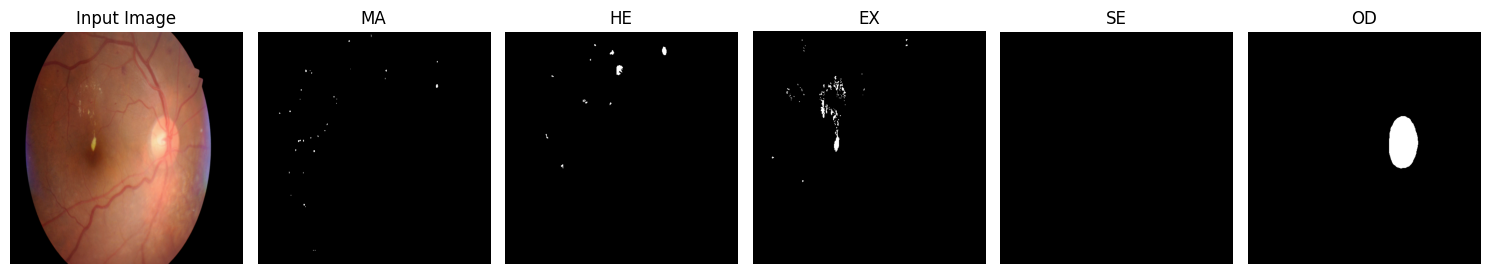

In [8]:
visualize_segmentation_sample(train_loader, n_samples=5)


In [9]:
train_loader

Model Definition : gated, seg head, cls head, overall multitaskmodel

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# --------------------------
# Gating Network
# --------------------------
class GatingNetwork(nn.Module):
    def __init__(self, input_dim=768):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        assert x.dim() == 2, f"Gating input must be (B, C), got {x.shape}"
        logits = self.net(x)                 # (B, 2)
        probs = F.softmax(logits, dim=1)    # (B, 2)
        return probs, logits

# --------------------------
# Classification Head
# --------------------------
class ClassificationHead(nn.Module):
    def __init__(self, in_features=768):
        super().__init__()
        self.retino = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(256, 5)
        )
        self.edema = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        assert x.dim() == 2, f"Classification input must be (B, C), got {x.shape}"
        retino = self.retino(x)  # (B, 5)
        edema = self.edema(x)    # (B, 3)
        return retino, edema

# --------------------------
# Segmentation Head
# --------------------------
class UpBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2)
        )

    def forward(self, x):
        return self.block(x)

class SegmentationHead(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.up1 = UpBlock(768, 256)
        self.up2 = UpBlock(256, 128)
        self.up3 = UpBlock(128, 64)
        self.up4 = UpBlock(64, 32)
        self.final = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        assert x.dim() == 4, f"Segmentation input must be (B, C, H, W), got {x.shape}"
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)
        x = F.interpolate(x, size=(512, 512), mode='bilinear', align_corners=False)
        return self.final(x)  # (B, 5, 512, 512)


In [6]:
class GatedMultiTaskModel(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.convnext_tiny(pretrained=True)
        self.encoder = base.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.cls_head = ClassificationHead()
        self.seg_head = SegmentationHead()
        self.gating_net = GatingNetwork()

    def forward(self, x):
        feats = self.encoder(x)
        pooled = self.pool(feats).squeeze(-1).squeeze(-1)

        gate_probs, gate_logits = self.gating_net(pooled)

        cls_retino, cls_edema = self.cls_head(pooled)
        seg_output = self.seg_head(feats)

        return {
            'cls_retino': cls_retino,
            'cls_edema': cls_edema,
            'seg_logits': seg_output,
            'gate_probs': gate_probs,
            'gate_logits': gate_logits
        }


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GatedMultiTaskModel().to(device)

#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 148MB/s]


In [ ]:
# Classification losses
cls_criterion = nn.CrossEntropyLoss()
# You can add FocalLoss later if needed

# Segmentation loss
def dice_loss(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

seg_criterion = nn.BCEWithLogitsLoss()


Train Loop

In [3]:
import torch
import torch.nn.functional as F

def dice_loss(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

def train(model, dataloader, optimizer, device, epoch, debug=False):
    model.train()

    total_loss_epoch = 0.0
    cls_loss_epoch = 0.0
    seg_loss_epoch = 0.0
    gate_loss_epoch = 0.0
    entropy_epoch = 0.0
    gate_acc_epoch = 0.0
    num_batches = len(dataloader)

    for batch_idx, (images, task_vecs, targets_cls, targets_seg) in enumerate(dataloader):
        images = images.to(device)
        task_vecs = task_vecs.to(device)

        outputs = model(images)
        gate_probs = outputs['gate_probs']
        gate_pred = gate_probs.argmax(dim=1)
        gate_true = task_vecs.argmax(dim=1)

        total_loss = 0.0
        cls_loss, seg_loss, gate_loss, entropy = 0.0, 0.0, 0.0, 0.0
        batch_size = images.size(0)

        # Classification Loss
        cls_mask = task_vecs[:, 1] == 1
        if cls_mask.any():
            cls_idx = cls_mask.nonzero(as_tuple=True)[0]
            retino_pred = outputs['cls_retino'][cls_idx]
            edema_pred = outputs['cls_edema'][cls_idx]
            labels = torch.stack([targets_cls[i] for i in cls_idx]).to(device)
            cls_loss = (F.cross_entropy(retino_pred, labels[:, 0]) +
                        F.cross_entropy(edema_pred, labels[:, 1])) / 2
            total_loss += (cls_mask.sum() / batch_size) * cls_loss

        # Segmentation Loss
        seg_mask = task_vecs[:, 0] == 1
        if seg_mask.any():
            seg_idx = seg_mask.nonzero(as_tuple=True)[0]
            seg_pred = outputs['seg_logits'][seg_idx]
            seg_true = torch.stack([targets_seg[i] for i in seg_idx]).to(device)
            bce = F.binary_cross_entropy_with_logits(seg_pred, seg_true)
            dice = dice_loss(seg_pred, seg_true)
            seg_loss = bce + dice
            total_loss += (seg_mask.sum() / batch_size) * seg_loss

        # Gating Loss + Entropy
        gate_loss = F.cross_entropy(outputs['gate_logits'], gate_true)
        entropy = -torch.sum(gate_probs * torch.log(gate_probs + 1e-8), dim=1).mean()
        total_loss += gate_loss + 0.01 * entropy

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Accumulate Metrics
        gate_acc = (gate_pred == gate_true).float().mean().item()
        total_loss_epoch += total_loss.item()
        cls_loss_epoch += cls_loss.item() if not isinstance(cls_loss, float) else cls_loss
        seg_loss_epoch += seg_loss.item() if not isinstance(seg_loss, float) else seg_loss
        gate_loss_epoch += gate_loss.item()
        entropy_epoch += entropy.item()
        gate_acc_epoch += gate_acc

        # Debug Logging
        if debug:
          print(f"\n[Epoch {epoch}] Batch {batch_idx+1}/{num_batches} | Batch Size: {batch_size}")
          print(f"   Gating Accuracy: {gate_acc:.2f}")
          print(f"   Task Split → CLS: {cls_mask.sum().item()}, SEG: {seg_mask.sum().item()}")
          print(f"   Losses → Total: {total_loss.item():.4f} | CLS: {cls_loss:.4f} | SEG: {seg_loss:.4f} | GATE: {gate_loss:.4f} | Entropy: {entropy.item():.4f}")

          for i in range(min(3, batch_size)):  # print only first 3 samples to reduce spam
              gt = "CLS" if task_vecs[i, 1] == 1 else "SEG"
              pred = "CLS" if gate_pred[i] == 1 else "SEG"
              mark = "ok" if gt == pred else "not-ok"
              print(f"      Sample {i}: GT={gt} | GATED={pred} {mark}")

    return {
        "total_loss": total_loss_epoch / num_batches,
        "cls_loss": cls_loss_epoch / num_batches,
        "seg_loss": seg_loss_epoch / num_batches,
        "gate_loss": gate_loss_epoch / num_batches,
        "entropy": entropy_epoch / num_batches,
        "gate_acc": gate_acc_epoch / num_batches
    }


In [ ]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
#model = GatedMultiTaskModel().to(device)

#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

#for epoch in range(1, 15):
#    train(model, train_loader, optimizer, device, epoch, debug=True)
#torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/metadata_idrid/gated_multitask_model_final.pt")


Begin train

In [20]:
# Setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GatedMultiTaskModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
epochs = 20

# History
history = {
    "total_loss": [], "cls_loss": [], "seg_loss": [],
    "gate_loss": [], "entropy": [], "gate_acc": []
}

# Training
for epoch in range(1, epochs + 1):
    metrics = train(model, train_loader, optimizer, device, epoch, debug=True)
    for k in history:
        history[k].append(metrics[k])

# Save model
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/metadata_idrid/gated_multitask_model_final.pt")


Streaming output truncated to the last 5000 lines.

[Epoch 17] Batch 52/169 | Batch Size: 4
   Gating Accuracy: 1.00
   Task Split → CLS: 2, SEG: 2
   Losses → Total: 0.5160 | CLS: 0.0795 | SEG: 0.7862 | GATE: 0.0813 | Entropy: 0.1883
      Sample 0: GT=SEG | GATED=SEG ok
      Sample 1: GT=CLS | GATED=CLS ok
      Sample 2: GT=SEG | GATED=SEG ok

[Epoch 17] Batch 53/169 | Batch Size: 4
   Gating Accuracy: 1.00
   Task Split → CLS: 2, SEG: 2
   Losses → Total: 0.3931 | CLS: 0.0158 | SEG: 0.7478 | GATE: 0.0108 | Entropy: 0.0469
      Sample 0: GT=SEG | GATED=SEG ok
      Sample 1: GT=CLS | GATED=CLS ok
      Sample 2: GT=CLS | GATED=CLS ok

[Epoch 17] Batch 54/169 | Batch Size: 4
   Gating Accuracy: 0.75
   Task Split → CLS: 2, SEG: 2
   Losses → Total: 0.6876 | CLS: 0.0590 | SEG: 0.7389 | GATE: 0.2866 | Entropy: 0.2054
      Sample 0: GT=CLS | GATED=CLS ok
      Sample 1: GT=SEG | GATED=SEG ok
      Sample 2: GT=CLS | GATED=SEG not-ok

[Epoch 17] Batch 55/169 | Batch Size: 4
   Gating 

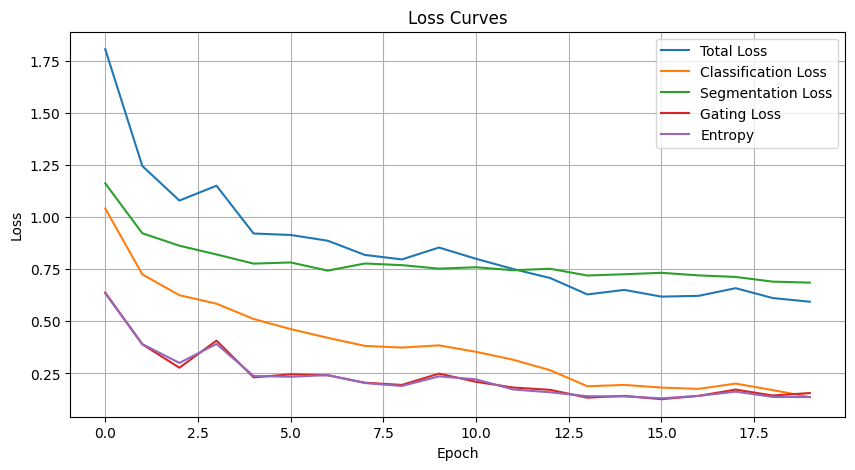

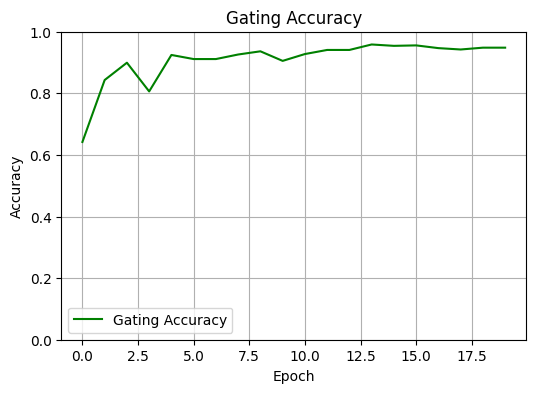

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history["total_loss"], label="Total Loss")
plt.plot(history["cls_loss"], label="Classification Loss")
plt.plot(history["seg_loss"], label="Segmentation Loss")
plt.plot(history["gate_loss"], label="Gating Loss")
plt.plot(history["entropy"], label="Entropy")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history["gate_acc"], label="Gating Accuracy", color="green")
plt.title("Gating Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()


Evaluation stage

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns

def evaluate_comprehensive2(model, dataloader, device, threshold=0.5,
                           class_names_seg=["MA", "HE", "EX", "SE", "OD"],
                           class_names_cls={"retino": ["None", "Mild", "Moderate", "Severe", "Proliferative"],
                                            "edema": ["None", "Mild", "Severe"]}):
    model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/metadata_idrid/gated_multitask_model_final.pt", map_location=device))
    model.to(device)
    model.eval()

    y_true_cls_retino, y_pred_cls_retino = [], []
    y_true_cls_edema, y_pred_cls_edema = [], []

    dice_all = [[] for _ in range(5)]  # per-class dice
    iou_all = [[] for _ in range(5)]   # per-class iou
    gate_correct, gate_total = 0, 0
    gate_y_true, gate_y_pred = [], []

    with torch.no_grad():
        for images, task_vecs, targets_cls, targets_seg in dataloader:
            images = images.to(device)
            task_vecs = task_vecs.to(device)

            outputs = model(images)
            gate_probs = outputs["gate_probs"]
            gate_pred = gate_probs.argmax(dim=1)
            gate_true = task_vecs.argmax(dim=1)

            gate_correct += (gate_pred == gate_true).sum().item()
            gate_total += len(gate_true)
            gate_y_true.extend(gate_true.cpu().numpy())
            gate_y_pred.extend(gate_pred.cpu().numpy())

            # Classification
            cls_mask = task_vecs[:, 1] == 1
            if cls_mask.any():
                idx = cls_mask.nonzero(as_tuple=True)[0]
                retino_logits = outputs["cls_retino"][idx]
                edema_logits = outputs["cls_edema"][idx]
                preds_r = retino_logits.argmax(dim=1).cpu().numpy()
                preds_e = edema_logits.argmax(dim=1).cpu().numpy()

                targets = torch.stack([targets_cls[i] for i in idx])
                gt_r = targets[:, 0].cpu().numpy()
                gt_e = targets[:, 1].cpu().numpy()

                y_true_cls_retino.extend(gt_r)
                y_pred_cls_retino.extend(preds_r)
                y_true_cls_edema.extend(gt_e)
                y_pred_cls_edema.extend(preds_e)

            # Segmentation
            seg_mask = task_vecs[:, 0] == 1
            if seg_mask.any():
                idx = seg_mask.nonzero(as_tuple=True)[0]
                pred_masks = torch.sigmoid(outputs["seg_logits"][idx]) > threshold
                true_masks = torch.stack([targets_seg[i] for i in idx]).to(device)

                for c in range(5):
                    pred_c = pred_masks[:, c]
                    true_c = (true_masks[:, c] > 0.5).float()
                    intersection = (pred_c * true_c).sum(dim=(1, 2))
                    union = ((pred_c + true_c) > 0).float().sum(dim=(1, 2))
                    dice = (2 * intersection) / (pred_c.sum(dim=(1,2)) + true_c.sum(dim=(1,2)) + 1e-8)
                    iou = (intersection + 1e-8) / (union + 1e-8)
                    dice_all[c].extend(dice.cpu().numpy())
                    iou_all[c].extend(iou.cpu().numpy())

    # ----- Classification Metrics -----
    print("\n Classification Metrics:")
    for name, y_true, y_pred, labels in [
        ("Retino", y_true_cls_retino, y_pred_cls_retino, class_names_cls["retino"]),
        ("Edema", y_true_cls_edema, y_pred_cls_edema, class_names_cls["edema"])
    ]:
        print(f"\n--- {name.upper()} ---")
        print(classification_report(y_true, y_pred, target_names=labels, digits=3))
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
        plt.title(f"{name} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    # ----- Segmentation Metrics -----
    print("\n Segmentation Metrics (per class):")
    dice_means = [np.mean(d) for d in dice_all]
    iou_means = [np.mean(i) for i in iou_all]

    for i, name in enumerate(class_names_seg):
        print(f"{name:<3} → Dice: {dice_means[i]:.3f} | IoU: {iou_means[i]:.3f}")

    x = np.arange(len(class_names_seg))
    width = 0.35
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(x - width/2, dice_means, width, label='Dice')
    ax.bar(x + width/2, iou_means, width, label='IoU')
    ax.set_ylabel('Score')
    ax.set_title('Segmentation Scores per Class')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names_seg)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # ----- Gating Evaluation -----
    gate_acc = gate_correct / gate_total
    print(f"\nGating Accuracy: {gate_correct}/{gate_total} → {gate_acc:.2%}")
    cm_gate = confusion_matrix(gate_y_true, gate_y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_gate, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["Seg", "Cls"], yticklabels=["Seg", "Cls"])
    plt.title("Gating Confusion Matrix")
    plt.xlabel("Predicted Task")
    plt.ylabel("Ground Truth Task")
    plt.tight_layout()
    plt.show()

    # ----- Trade-off Commentary -----
    print("\n Trade-off Insight:")
    print("- High classification accuracy often aligns with good gating decisions.")
    print("- If gating misroutes (e.g., seg → cls), loss is suppressed, but it affects training efficiency.")
    print("- Dice/IoU variations across lesion classes show generalization limits on rare classes.")



 Classification Metrics:

--- RETINO ---
               precision    recall  f1-score   support

         None      0.897     0.963     0.929        27
         Mild      0.000     0.000     0.000         5
     Moderate      0.750     0.714     0.732        21
       Severe      0.474     0.643     0.545        14
Proliferative      0.545     0.500     0.522        12

     accuracy                          0.709        79
    macro avg      0.533     0.564     0.545        79
 weighted avg      0.673     0.709     0.688        79



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


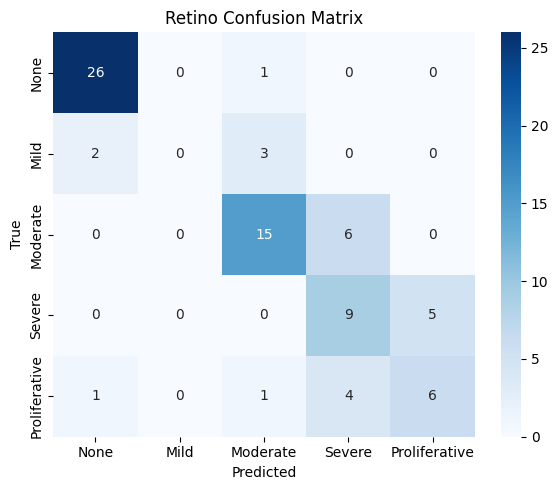


--- EDEMA ---
              precision    recall  f1-score   support

        None      0.970     0.941     0.955        34
        Mild      0.600     0.500     0.545         6
      Severe      0.927     0.974     0.950        39

    accuracy                          0.924        79
   macro avg      0.832     0.805     0.817        79
weighted avg      0.920     0.924     0.922        79



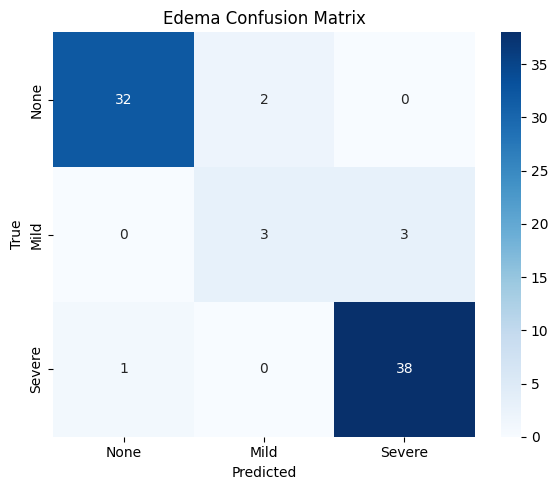


 Segmentation Metrics (per class):
MA  → Dice: 0.000 | IoU: 0.000
HE  → Dice: 0.151 | IoU: 0.094
EX  → Dice: 0.207 | IoU: 0.124
SE  → Dice: 0.255 | IoU: 0.245
OD  → Dice: 0.966 | IoU: 0.935


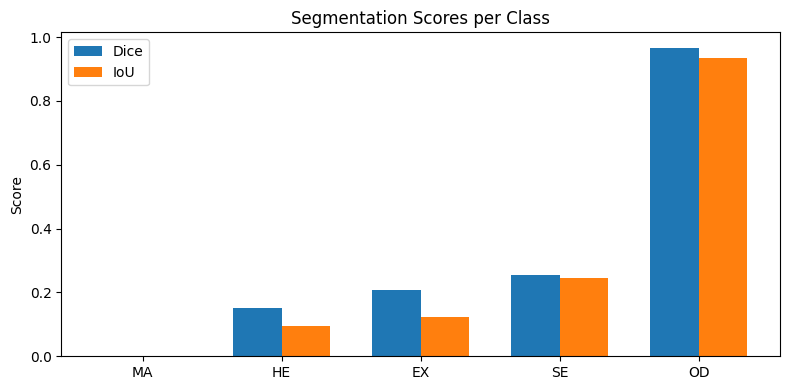


Gating Accuracy: 143/169 → 84.62%


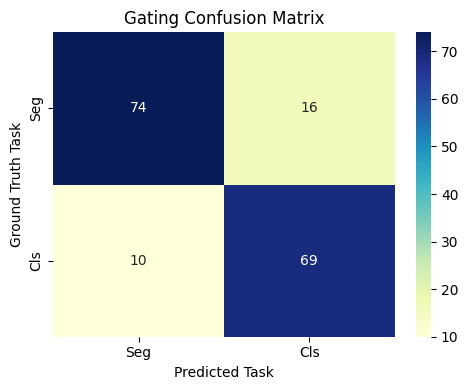


 Trade-off Insight:
- High classification accuracy often aligns with good gating decisions.
- If gating misroutes (e.g., seg → cls), loss is suppressed, but it affects training efficiency.
- Dice/IoU variations across lesion classes show generalization limits on rare classes.


In [15]:
evaluate_comprehensive2(model, test_loader, device)


Prediction


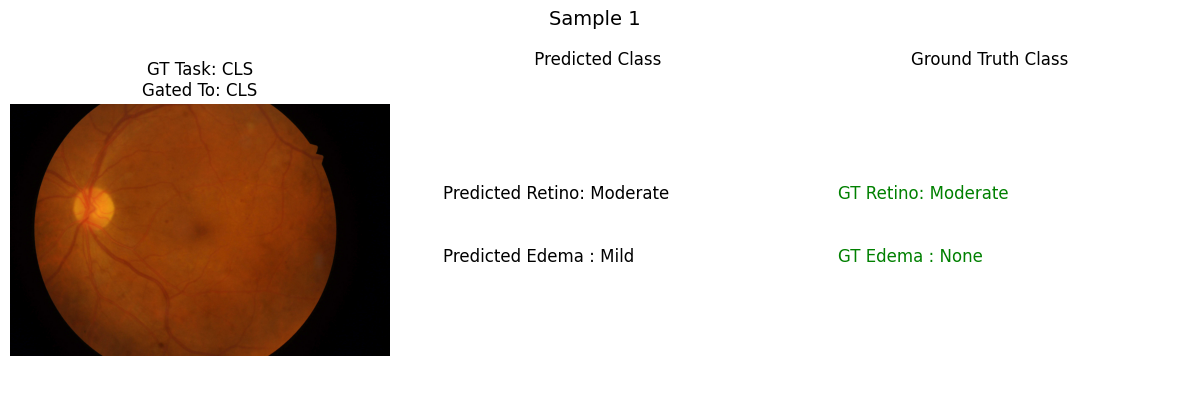

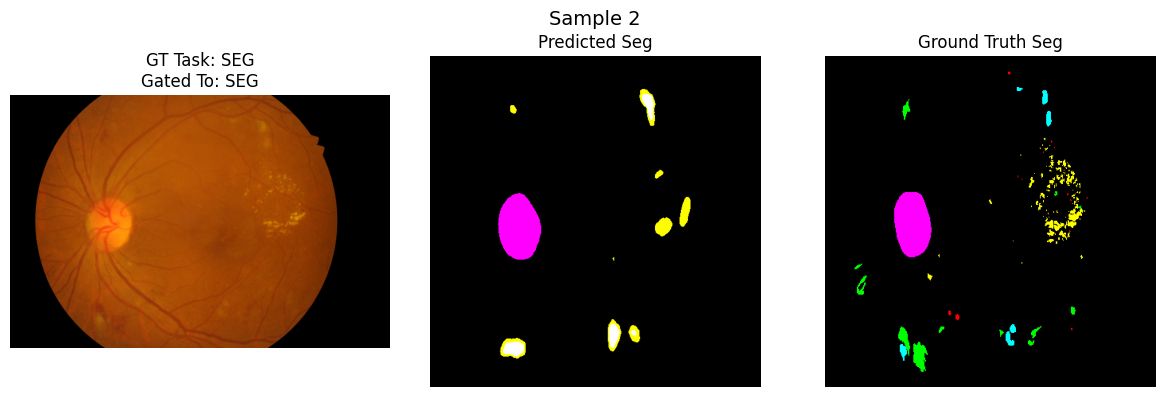

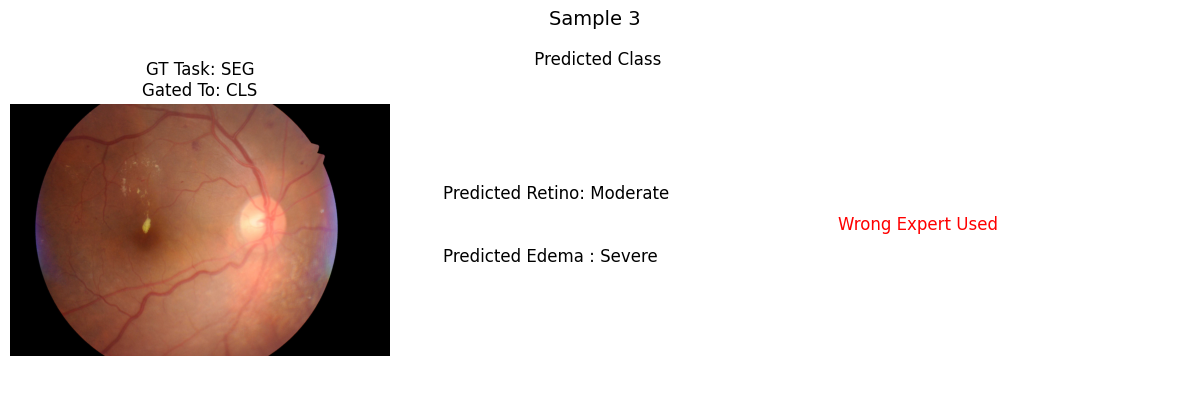

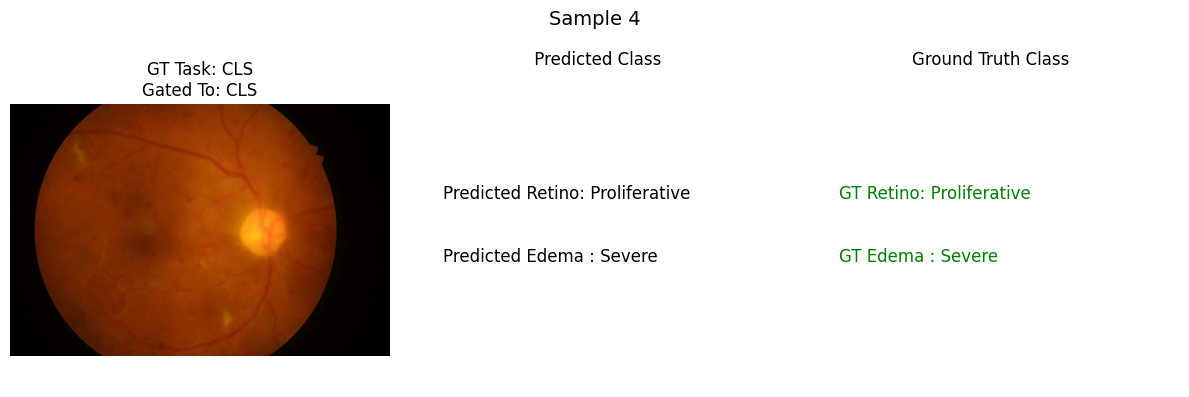

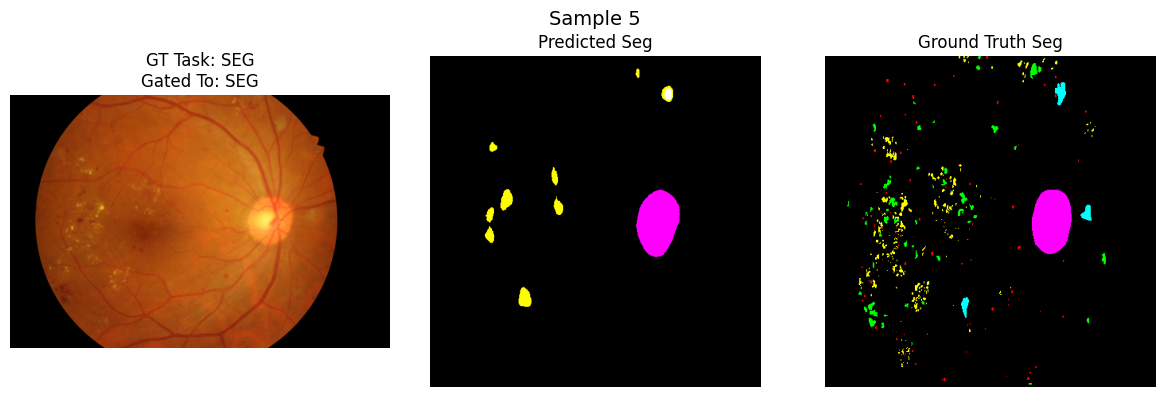

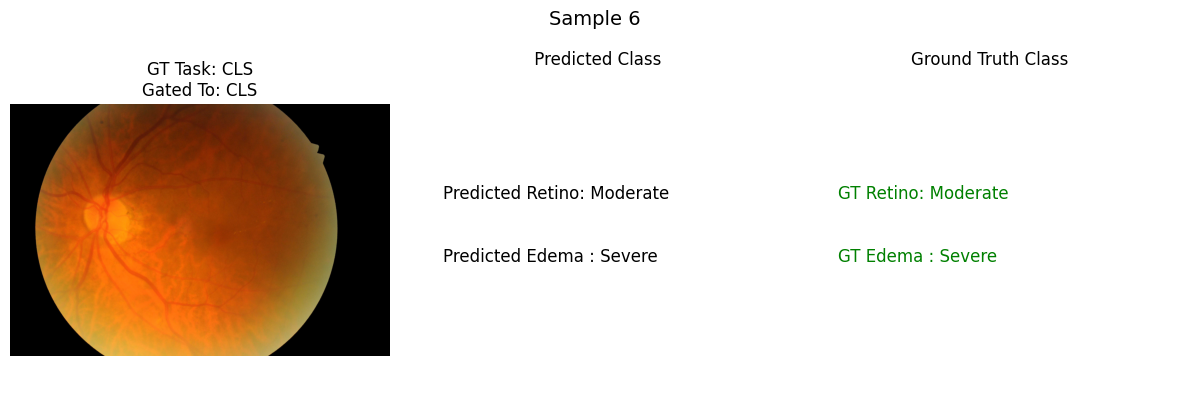

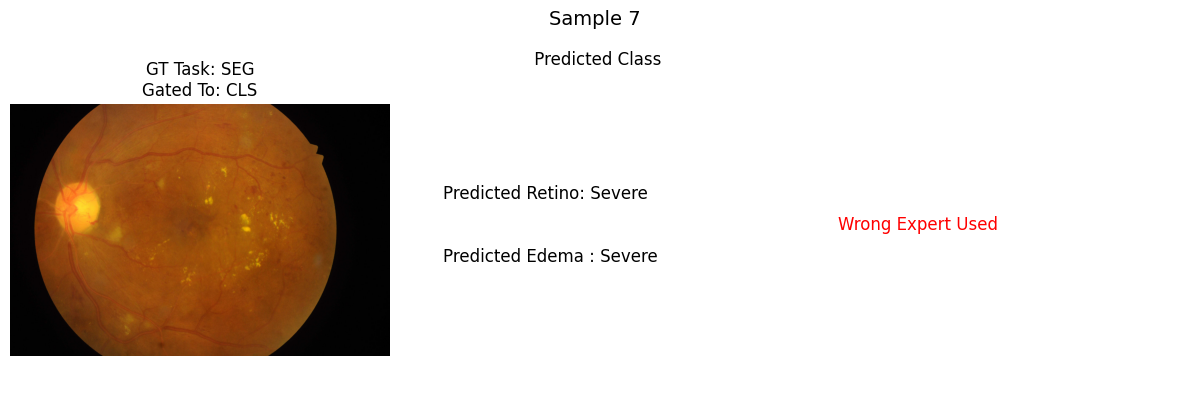

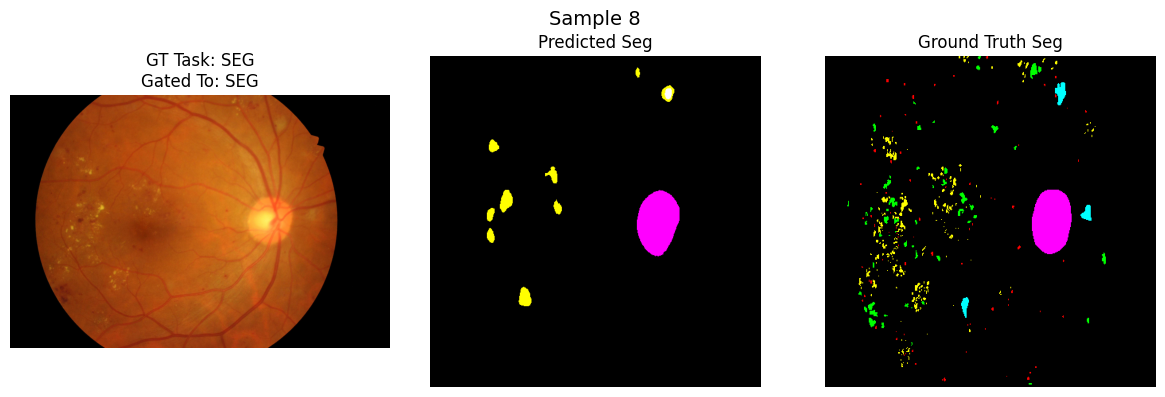

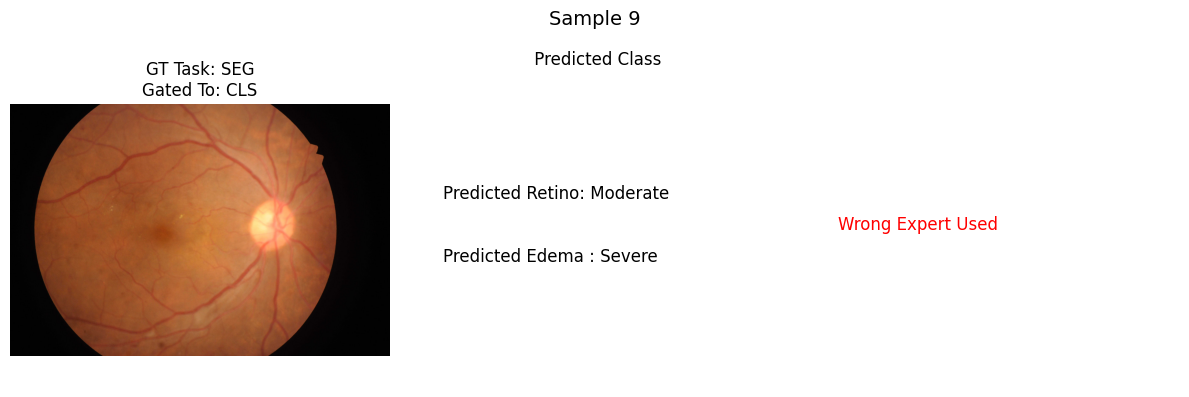

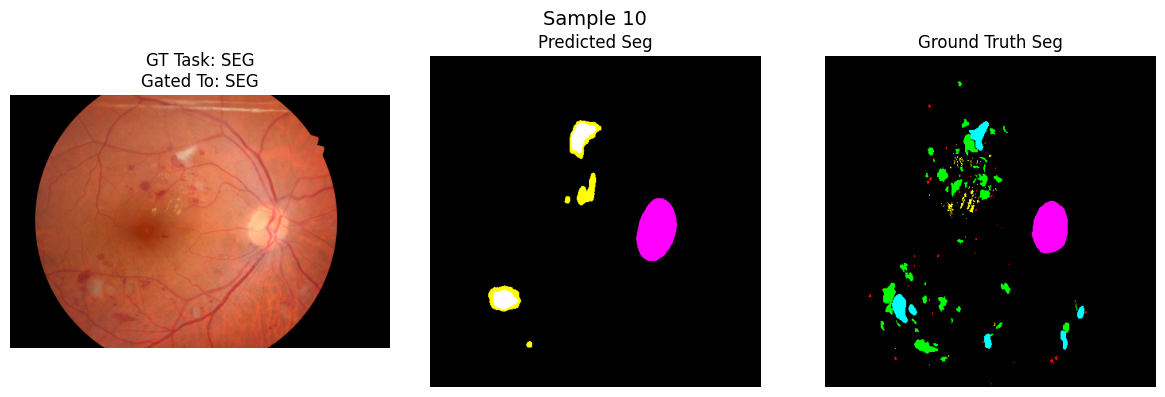

In [18]:
import json
import random
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
import cv2
import os

# -------------------------
# Load Your Model Here
# -------------------------
# Update path
model_weights = "/content/drive/MyDrive/Colab Notebooks/metadata_idrid/gated_multitask_model_final.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"



transform = T.Compose([
    T.Resize((416, 416)),
     T.ColorJitter(brightness=0.1, contrast=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

class_names = ["MA", "HE", "EX", "SE", "OD"]
retino_labels = ["None", "Mild", "Moderate", "Severe", "Proliferative"]
edema_labels = ["None", "Mild", "Severe"]

# -------------------------
# Load Model
# -------------------------
model = GatedMultiTaskModel().to(device)
model.load_state_dict(torch.load(model_weights, map_location=device))
model.eval()

# -------------------------
# Load Metadata
# -------------------------
with open("/content/drive/MyDrive/Colab Notebooks/metadata_idrid/balanced_idrid_metadata.json") as f:
    metadata = json.load(f)

samples = random.sample(metadata, 10)

# -------------------------
# Prediction Loop
# -------------------------
for idx, entry in enumerate(samples):
    img = Image.open(entry["image_path"]).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    gt_task = "seg" if entry["task_vector"][0] == 1 else "cls"

    with torch.no_grad():
        output = model(img_tensor)
        gate_probs = output["gate_probs"]
        gate_pred = gate_probs.argmax(dim=1).item()
        routed_task = "seg" if gate_pred == 0 else "cls"

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(img)
        axs[0].set_title(f"GT Task: {gt_task.upper()}\nGated To: {routed_task.upper()}")
        axs[0].axis("off")

        if routed_task == "seg":
            seg_pred = torch.sigmoid(output["seg_logits"])[0].cpu().numpy()
            combined_pred = np.zeros((512, 512, 3), dtype=np.uint8)
            colors = [(255, 0, 0), (0, 255, 0), (255, 255, 0), (0, 255, 255), (255, 0, 255)]
            for i, mask in enumerate(seg_pred):
                mask = (mask > 0.5).astype(np.uint8)
                for c in range(3):
                    combined_pred[..., c] += mask * colors[i][c]
            axs[1].imshow(combined_pred)
            axs[1].set_title("Predicted Seg")
            axs[1].axis("off")

            if gt_task == "seg":
                gt_masks = []
                for k in class_names:
                    mask_path = entry["mask_paths"].get(k)
                    if mask_path:
                        mask = Image.open(mask_path).resize((416, 416))
                        mask = np.array(mask) > 0
                    else:
                        mask = np.zeros((416, 416))
                    gt_masks.append(mask.astype(np.uint8))

                combined_gt = np.zeros((416, 416, 3), dtype=np.uint8)
                for i, mask in enumerate(gt_masks):
                    for c in range(3):
                        combined_gt[..., c] += mask * colors[i][c]
                axs[2].imshow(combined_gt)
                axs[2].set_title("Ground Truth Seg")
                axs[2].axis("off")
            else:
                axs[2].text(0.1, 0.5, "Wrong Expert Used", color="red", fontsize=12)
                axs[2].axis("off")

        elif routed_task == "cls":
            retino_pred = torch.softmax(output["cls_retino"], dim=1)[0].cpu().numpy()
            edema_pred = torch.softmax(output["cls_edema"], dim=1)[0].cpu().numpy()

            pred_retino = retino_pred.argmax()
            pred_edema = edema_pred.argmax()

            axs[1].text(0.1, 0.6, f"Predicted Retino: {retino_labels[pred_retino]}", fontsize=12)
            axs[1].text(0.1, 0.4, f"Predicted Edema : {edema_labels[pred_edema]}", fontsize=12)
            axs[1].axis("off")
            axs[1].set_title(" Predicted Class")

            if gt_task == "cls":
                gt_r = entry["retino_label"]
                gt_e = entry["edema_label"]
                axs[2].text(0.1, 0.6, f"GT Retino: {retino_labels[gt_r]}", fontsize=12, color="green")
                axs[2].text(0.1, 0.4, f"GT Edema : {edema_labels[gt_e]}", fontsize=12, color="green")
                axs[2].axis("off")
                axs[2].set_title("Ground Truth Class")
            else:
                axs[2].text(0.1, 0.5, "Wrong Expert Used", color="red", fontsize=12)
                axs[2].axis("off")

        plt.suptitle(f"Sample {idx+1}", fontsize=14)
        plt.tight_layout()
        plt.show()
